In [4]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np

file_path = '/Users/djem/Desktop/data/dataset_55_hepatitis.arff'

data, meta = arff.loadarff(file_path)
df = pd.DataFrame(data)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

pd.set_option('display.max_columns', None)
# print(df.head())
print(df.info())
# print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              155 non-null    float64
 1   SEX              155 non-null    object 
 2   STEROID          155 non-null    object 
 3   ANTIVIRALS       155 non-null    object 
 4   FATIGUE          155 non-null    object 
 5   MALAISE          155 non-null    object 
 6   ANOREXIA         155 non-null    object 
 7   LIVER_BIG        155 non-null    object 
 8   LIVER_FIRM       155 non-null    object 
 9   SPLEEN_PALPABLE  155 non-null    object 
 10  SPIDERS          155 non-null    object 
 11  ASCITES          155 non-null    object 
 12  VARICES          155 non-null    object 
 13  BILIRUBIN        149 non-null    float64
 14  ALK_PHOSPHATE    126 non-null    float64
 15  SGOT             151 non-null    float64
 16  ALBUMIN          139 non-null    float64
 17  PROTIME         

In [5]:
missing_values = df.isnull().sum()
print(missing_values)

AGE                 0
SEX                 0
STEROID             0
ANTIVIRALS          0
FATIGUE             0
MALAISE             0
ANOREXIA            0
LIVER_BIG           0
LIVER_FIRM          0
SPLEEN_PALPABLE     0
SPIDERS             0
ASCITES             0
VARICES             0
BILIRUBIN           6
ALK_PHOSPHATE      29
SGOT                4
ALBUMIN            16
PROTIME            67
HISTOLOGY           0
Class               0
dtype: int64


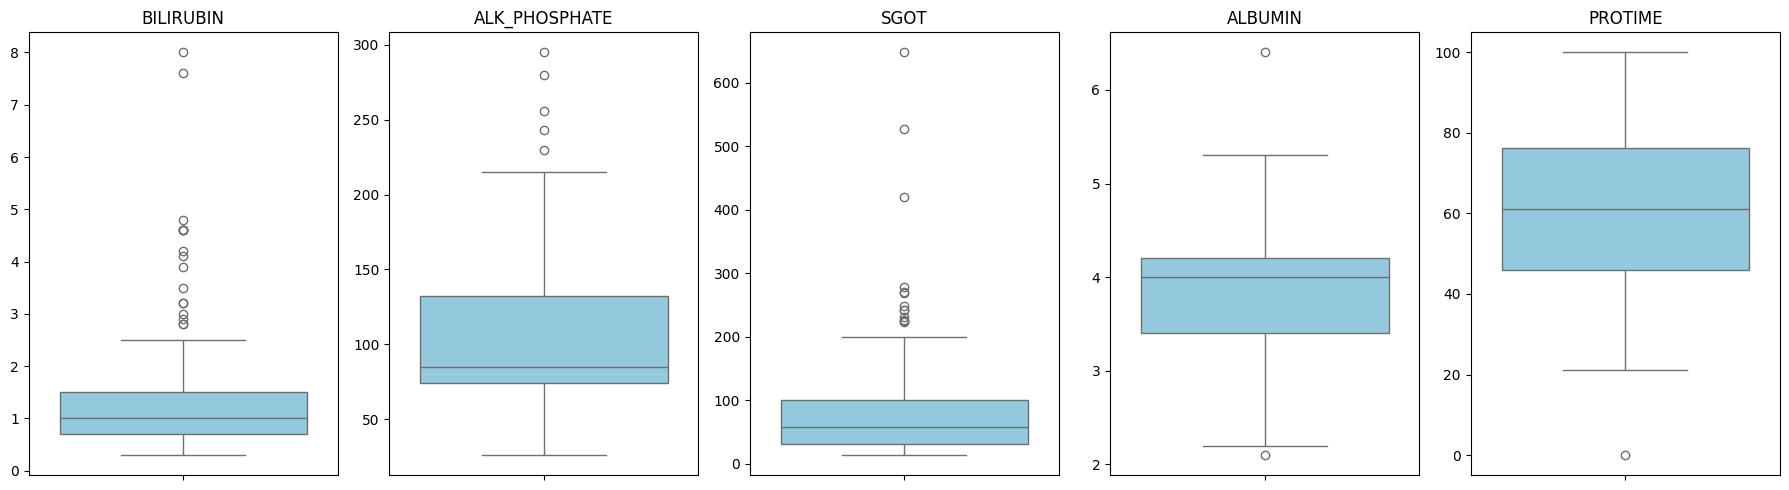

In [6]:
columns = ['BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(18, 5))


for i, col in enumerate(columns):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


plt.tight_layout()
plt.show()

In [7]:
# Imputer with median strategy — suitable for skewed data and outliers
median_imputer = SimpleImputer(strategy='median')

# Impute BILIRUBIN (few outliers — use median)
df['BILIRUBIN'] = median_imputer.fit_transform(df[['BILIRUBIN']])

# Impute ALK_PHOSPHATE (strong right-skewed — use median)
df['ALK_PHOSPHATE'] = median_imputer.fit_transform(df[['ALK_PHOSPHATE']])

# Impute SGOT (long tail — use median)
df['SGOT'] = median_imputer.fit_transform(df[['SGOT']])

# Impute ALBUMIN (fairly normal — can use mean or median)
# Let's use mean here for variation
mean_imputer = SimpleImputer(strategy='mean')
df['ALBUMIN'] = mean_imputer.fit_transform(df[['ALBUMIN']])


In [8]:
# missing_values = df.isnull().sum()
# print(missing_values)

In [9]:
# PROTIME: high number of missing values and a possible outlier at 0
# Create missing flag before imputation
df['PROTIME_missing'] = df['PROTIME'].isnull().astype(int)

# Replace 0 with NaN if 0 is invalid
df['PROTIME'] = df['PROTIME'].replace(0, np.nan)

# Impute PROTIME using median
df['PROTIME'] = median_imputer.fit_transform(df[['PROTIME']])

missing_values = df.isnull().sum()
print(missing_values)

AGE                0
SEX                0
STEROID            0
ANTIVIRALS         0
FATIGUE            0
MALAISE            0
ANOREXIA           0
LIVER_BIG          0
LIVER_FIRM         0
SPLEEN_PALPABLE    0
SPIDERS            0
ASCITES            0
VARICES            0
BILIRUBIN          0
ALK_PHOSPHATE      0
SGOT               0
ALBUMIN            0
PROTIME            0
HISTOLOGY          0
Class              0
PROTIME_missing    0
dtype: int64


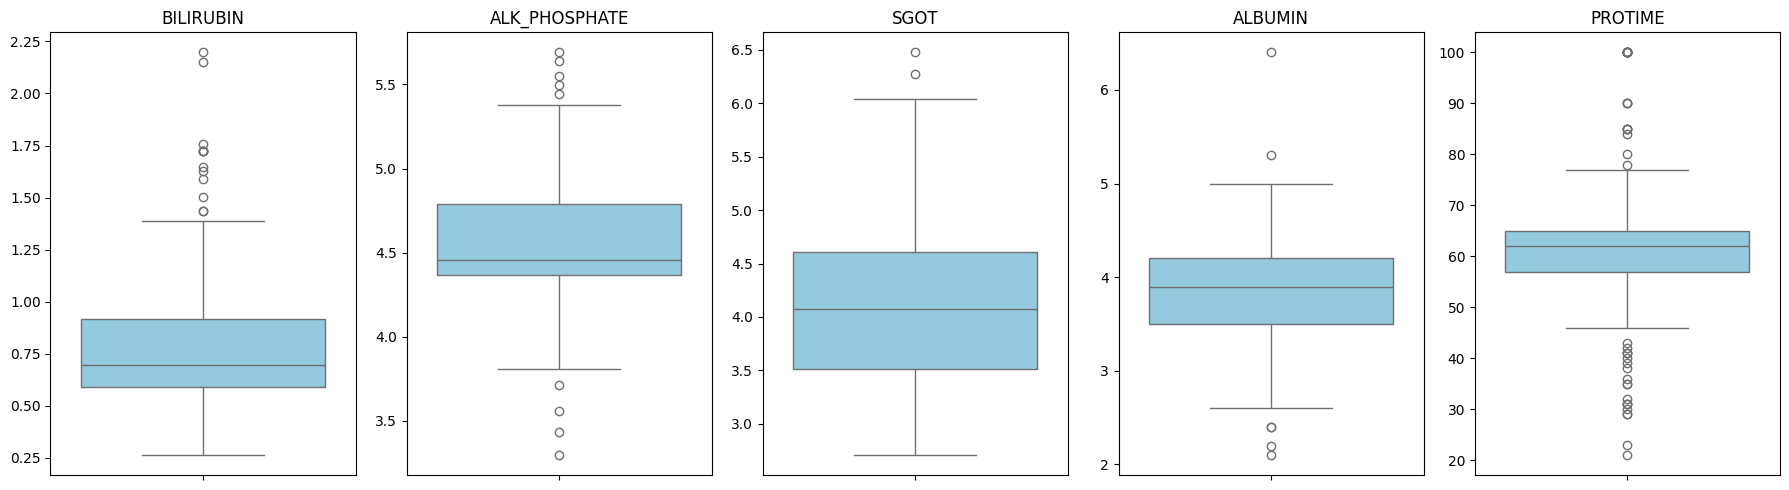

In [10]:
# List of skewed features with visible outliers
log_transform_cols = ['SGOT', 'ALK_PHOSPHATE', 'BILIRUBIN']

# Apply np.log1p(x) = log(1 + x), which handles zeros and is numerically stable
for col in log_transform_cols:
    # Check if the column has negative values (log1p cannot handle them)
    if (df[col] < 0).any():
        print(f"Warning: Negative values found in {col}. Log transform skipped.")
    else:
        df[col] = np.log1p(df[col])
        
columns = ['BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']

fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(18, 5))


for i, col in enumerate(columns):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


plt.tight_layout()
plt.show()


In [11]:
# Define binary mappings for categorical features

binary_mapping = {
    'no': 0,
    'yes': 1,
    'male': 1,
    'female': 0,
    'DIE': 1,
    'LIVE': 0
}

# Apply mapping to relevant columns
binary_columns = [
    'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE',
    'ANOREXIA', 'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE',
    'SPIDERS', 'ASCITES', 'VARICES', 'HISTOLOGY', 'Class'
]

for col in binary_columns:
    df[col] = df[col].map(binary_mapping)

# Check if there are any missing values after mapping
print(df[binary_columns].isnull().sum())

# Optionally, check the unique values to make sure mapping worked
for col in binary_columns:
    print(f"{col} unique values: {df[col].unique()}")

SEX                 0
STEROID             1
ANTIVIRALS          0
FATIGUE             1
MALAISE             1
ANOREXIA            1
LIVER_BIG          10
LIVER_FIRM         11
SPLEEN_PALPABLE     5
SPIDERS             5
ASCITES             5
VARICES             5
HISTOLOGY           0
Class               0
dtype: int64
SEX unique values: [1 0]
STEROID unique values: [ 0.  1. nan]
ANTIVIRALS unique values: [0 1]
FATIGUE unique values: [ 0.  1. nan]
MALAISE unique values: [ 0.  1. nan]
ANOREXIA unique values: [ 0.  1. nan]
LIVER_BIG unique values: [ 0.  1. nan]
LIVER_FIRM unique values: [ 0.  1. nan]
SPLEEN_PALPABLE unique values: [ 0.  1. nan]
SPIDERS unique values: [ 0.  1. nan]
ASCITES unique values: [ 0.  1. nan]
VARICES unique values: [ 0. nan  1.]
HISTOLOGY unique values: [0 1]
Class unique values: [0 1]


In [12]:
from sklearn.impute import SimpleImputer

# Create an imputer that fills missing values with the most frequent value
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

# List of binary columns with missing values
cols_with_nans = [
    'STEROID', 'FATIGUE', 'MALAISE', 'ANOREXIA',
    'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE',
    'SPIDERS', 'ASCITES', 'VARICES'
]

# Apply the imputer to the selected columns
df[cols_with_nans] = most_frequent_imputer.fit_transform(df[cols_with_nans])

# Check if there are still any missing values
print(df[cols_with_nans].isnull().sum())


STEROID            0
FATIGUE            0
MALAISE            0
ANOREXIA           0
LIVER_BIG          0
LIVER_FIRM         0
SPLEEN_PALPABLE    0
SPIDERS            0
ASCITES            0
VARICES            0
dtype: int64


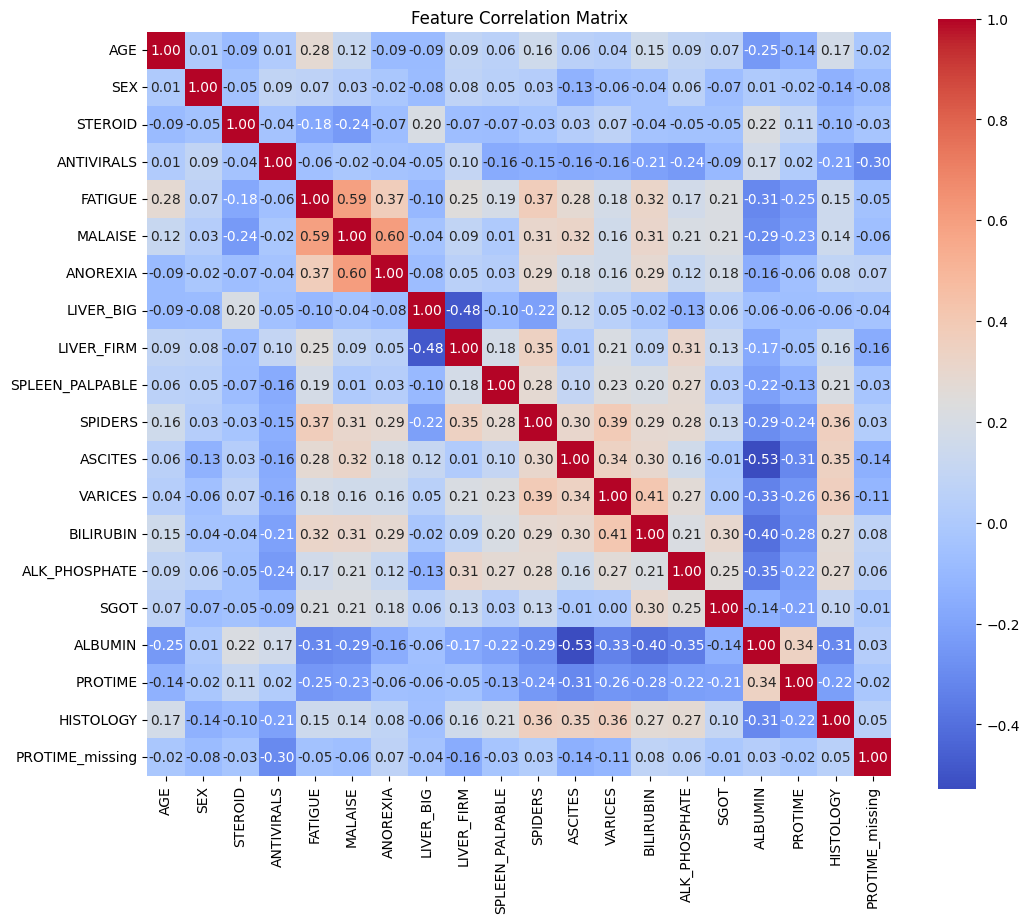

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.drop(columns='Class').corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Feature Correlation Matrix')
plt.show()


In [14]:

correlations = df.corr(numeric_only=True)['Class'].drop('Class')  # уберем саму себя


correlations_sorted = correlations.abs().sort_values(ascending=False)

print("Top features correlated with Class:")
print(correlations_sorted.head(10))


Top features correlated with Class:
ASCITES            0.469334
ALBUMIN            0.465827
BILIRUBIN          0.444897
SPIDERS            0.389137
VARICES            0.362385
MALAISE            0.339530
HISTOLOGY          0.337856
PROTIME            0.333565
FATIGUE            0.306049
SPLEEN_PALPABLE    0.234261
Name: Class, dtype: float64


In [15]:
from sklearn.model_selection import train_test_split

#Define feature matrix (X) and target vector (y)

X = df.drop(columns=['Class'])  # All features except the target
y = df['Class']                 # Target variable (0 = LIVE, 1 = DIE)

In [16]:
#Perform stratified train-test split to preserve class proportions

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% of the data for testing
    random_state=42,      # For reproducibility
    stratify=y            # Preserve class distribution
)

# Check the resulting shapes and class balance
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

Train shape: (124, 20), Test shape: (31, 20)
Train target distribution:
 Class
0    0.790323
1    0.209677
Name: proportion, dtype: float64
Test target distribution:
 Class
0    0.806452
1    0.193548
Name: proportion, dtype: float64


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

# Set hyperparameters
k = 5
weights = 'uniform'
metric = 'euclidean'

# Start timer
start_time = time.time()

# Initialize and fit k-NN classifier
knn = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
knn.fit(X_train, y_train)

# Predict on test set
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# End timer
runtime = time.time() - start_time

# Print results
print(f"k = {k}, weights = {weights}, metric = {metric}")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print(f"Runtime (seconds): {runtime:.2f}")

k = 5, weights = uniform, metric = euclidean
Accuracy: 0.8387, Precision: 0.6667, Recall: 0.3333, F1: 0.4444, ROC AUC: 0.7733
Runtime (seconds): 0.06


In [18]:
from sklearn.model_selection import cross_validate

# Define the metrics you want
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Start timer
start_time = time.time()

# Perform cross-validation
cv_results = cross_validate(knn, X, y, cv=cv, scoring=scoring, return_train_score=False)

# End timer
cv_runtime = time.time() - start_time

# Print average results
for metric in scoring:
    print(f"CV {metric}: {np.mean(cv_results[f'test_{metric}']):.4f} ± {np.std(cv_results[f'test_{metric}']):.4f}")

print(f"CV Runtime (seconds): {cv_runtime:.2f}")


NameError: name 'cv' is not defined

In [ ]:
accuracy_knn = accuracy
precision_knn = precision
recall_knn = recall
f1_knn = f1
roc_auc_knn = roc_auc
runtime_knn = runtime


Decision Tree (Holdout)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Set hyperparameters
max_depth = 5
random_state = 42

# Start timer
start_time = time.time()

# Initialize and fit the Decision Tree
tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
tree.fit(X_train, y_train)

# Predict on test set
y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# End timer
runtime = time.time() - start_time

# Print results
print(f"Decision Tree (max_depth = {max_depth})")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print(f"Runtime (seconds): {runtime:.2f}")


Decision Tree (max_depth = 5)
Accuracy: 0.7742, Precision: 0.4000, Recall: 0.3333, F1: 0.3636, ROC AUC: 0.5300
Runtime (seconds): 0.03


Decision Tree (CV)



In [ ]:
# Start timer
start_time = time.time()

# Evaluate multiple metrics with cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(tree, X, y, cv=cv, scoring=scoring)

# End timer
cv_runtime = time.time() - start_time

# Print average results
print("\nCross-Validation Results (Decision Tree):")
for metric in scoring:
    print(f"CV {metric}: {np.mean(cv_results[f'test_{metric}']):.4f} ± {np.std(cv_results[f'test_{metric}']):.4f}")
print(f"CV Runtime (seconds): {cv_runtime:.2f}")


Cross-Validation Results (Decision Tree):
CV accuracy: 0.7548 ± 0.0664
CV precision: 0.4277 ± 0.1214
CV recall: 0.4714 ± 0.1432
CV f1: 0.4422 ± 0.1223
CV roc_auc: 0.6693 ± 0.0960
CV Runtime (seconds): 0.05


In [ ]:
accuracy_dt = accuracy
precision_dt = precision
recall_dt = recall
f1_dt = f1
roc_auc_dt = roc_auc
runtime_dt = runtime


MLP(Holdout)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Set MLP hyperparameters
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Start timer
start_time = time.time()

# Train the MLP classifier
mlp.fit(X_train, y_train)

# Predict on test set
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# End timer
runtime = time.time() - start_time

# Print holdout results
print("MLP Classifier (1 hidden layer, 100 neurons)")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print(f"Runtime (seconds): {runtime:.2f}")


MLP Classifier (1 hidden layer, 100 neurons)
Accuracy: 0.8710, Precision: 0.6667, Recall: 0.6667, F1: 0.6667, ROC AUC: 0.9133
Runtime (seconds): 0.21


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP(CV)

In [ ]:
# Start timer
start_time = time.time()

# Cross-validation with multiple metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(mlp, X, y, cv=cv, scoring=scoring)

# End timer
cv_runtime = time.time() - start_time

# Print CV results
print("\nCross-Validation Results (MLP Classifier):")
for metric in scoring:
    print(f"CV {metric}: {np.mean(cv_results[f'test_{metric}']):.4f} ± {np.std(cv_results[f'test_{metric}']):.4f}")
print(f"CV Runtime (seconds): {cv_runtime:.2f}")



Cross-Validation Results (MLP Classifier):
CV accuracy: 0.8452 ± 0.0376
CV precision: 0.6330 ± 0.0923
CV recall: 0.6619 ± 0.0957
CV f1: 0.6407 ± 0.0607
CV roc_auc: 0.8500 ± 0.0730
CV Runtime (seconds): 0.87


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
accuracy_mlp = accuracy
precision_mlp = precision
recall_mlp = recall
f1_mlp = f1
roc_auc_mlp = roc_auc
runtime_mlp = runtime


In [ ]:
# Create results list
results = [
    {
        'Model': 'k-NN',
        'Parameters': 'k=5, weights=uniform, metric=euclidean',
        'Accuracy': round(accuracy_knn, 4),
        'Precision': round(precision_knn, 4),
        'Recall': round(recall_knn, 4),
        'F1 Score': round(f1_knn, 4),
        'ROC AUC': round(roc_auc_knn, 4),
        'Runtime (sec)': round(runtime_knn, 2)
    },
    {
        'Model': 'Decision Tree',
        'Parameters': 'max_depth=5',
        'Accuracy': round(accuracy_dt, 4),
        'Precision': round(precision_dt, 4),
        'Recall': round(recall_dt, 4),
        'F1 Score': round(f1_dt, 4),
        'ROC AUC': round(roc_auc_dt, 4),
        'Runtime (sec)': round(runtime_dt, 2)
    },
    {
        'Model': 'MLP',
        'Parameters': 'hidden_layer_sizes=(100,), max_iter=1000',
        'Accuracy': round(accuracy_mlp, 4),
        'Precision': round(precision_mlp, 4),
        'Recall': round(recall_mlp, 4),
        'F1 Score': round(f1_mlp, 4),
        'ROC AUC': round(roc_auc_mlp, 4),
        'Runtime (sec)': round(runtime_mlp, 2)
    }
]

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by ROC AUC (optional, if you want to show the best model on top)
results_df = results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)

# Display
results_df


,Model,Parameters,Accuracy,Precision,Recall,F1 Score,ROC AUC,Runtime (sec)
0,MLP,"hidden_layer_sizes=(100,), max_iter=1000",0.8710,0.6667,0.6667,0.6667,0.9133,0.21
1,k-NN,"k=5, weights=uniform, metric=euclidean",0.8387,0.6667,0.3333,0.4444,0.7733,0.04
2,Decision Tree,max_depth=5,0.7742,0.4000,0.3333,0.3636,0.5300,0.03


In [20]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Models
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Cross-validation
cv_knn = cross_validate(knn, X, y, cv=cv, scoring=scoring)
cv_dt = cross_validate(tree, X, y, cv=cv, scoring=scoring)
cv_mlp = cross_validate(mlp, X, y, cv=cv, scoring=scoring)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
import numpy as np
import pandas as pd


# Example CV results from cross_validate() for each model
# (replace these with your real cv_results objects)

# For k-NN
cv_knn = cross_validate(knn, X, y, cv=cv, scoring=scoring, return_train_score=False)

# For Decision Tree
cv_dt = cross_validate(tree, X, y, cv=cv, scoring=scoring, return_train_score=False)

# For MLP
cv_mlp = cross_validate(mlp, X, y, cv=cv, scoring=scoring, return_train_score=False)

# Function to summarize CV results
def summarize_cv(cv_result, model_name):
    return {
        'Model': model_name,
        'CV Accuracy': np.mean(cv_result['test_accuracy']),
        'CV Precision': np.mean(cv_result['test_precision']),
        'CV Recall': np.mean(cv_result['test_recall']),
        'CV F1 Score': np.mean(cv_result['test_f1']),
        'CV ROC AUC': np.mean(cv_result['test_roc_auc'])
    }

# Collect summaries
cv_results = [
    summarize_cv(cv_knn, 'k-NN'),
    summarize_cv(cv_dt, 'Decision Tree'),
    summarize_cv(cv_mlp, 'MLP')
]

# Create a DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Round values for prettier display
cv_results_df = cv_results_df.round(4)

# Display
cv_results_df


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score,CV ROC AUC
0,k-NN,0.7935,0.5467,0.3810,0.4403,0.6960
1,Decision Tree,0.7548,0.4277,0.4714,0.4422,0.6693
2,MLP,0.8452,0.6330,0.6619,0.6407,0.8500
